In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from functools import partial
from rl_analysis.plotting import (
    setup_plotting_env,
    geno_palette,
    syllable_aliases,
    savefig,
    clean_ticks
)
from rl_analysis.util import (
    rle,
)
from rl_analysis.batch import apply_parallel_joblib
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import pandas as pd

import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Read in raw data to process transition stats

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
closed_loop_cfg = analysis_config["closed_loop_behavior"]
figure_cfg = analysis_config["figures"]

# Load in raw data and normalize (can skip if loading pre-computed results)

In [5]:
feedback_df = pd.read_parquet(
    os.path.join(raw_dirs["closed_loop_behavior"], "closed_loop_behavior_with_simulated_triggers.parquet")
).sort_index()

In [6]:
feedback_df = feedback_df.loc[
    (feedback_df["area"].isin(["snc (axon)", "snc (axon, dms)", "ctrl"]))
    & (feedback_df["opsin"].isin(["chr2", "ctrl"]))
    & (feedback_df["session_number"].isin([-1, 0, 1, 2]).copy())
    & (feedback_df["target_syllable"].isin(syllable_aliases.keys()))
].copy()

## First build the null distribution using random splits over the baseline data

In [7]:
from collections import defaultdict
from functools import partial
import warnings

In [8]:
stim_len = 0  # set to length of stim (in seconds) if you want to reference to offset
lags = np.arange(-50, 51)  # which lags (in syllable time) to check
dfs = []
meta_keys = [
    "mouse_id",
    # "uuid",
    "session_number",
    "stim_duration",
    "cohort",
    "genotype",
    "target_syllable",
    "area",
    "opsin",
    "power",
    "experiment_type",
    "area (pooled)",
]

def get_trans_stats(
    session,
    sim_prefix="sim_feedback_status target_{}",
    catch_rate=0.25,
    nlags=3,
    target=None,
):
    session = session.copy().set_index(
        "timestamp"
    )  # so we're indexing by, you know, time...

    # get the indices for syllable onsets
    rle_labels = rle(session["predicted_syllable"])
    labels_idx = rle_labels.index
    sim_key = sim_prefix.format(session["target_syllable"].iat[0])

    # use the sim_key if we're on a baseline day...
    session_number = session["session_number"].iat[0]
    if (session_number <= 0) or (session_number >= 3):
        fback_key = sim_key
        session_type = "control"
        sim_catch = True
    else:
        fback_key = "feedback_status"
        session_type = "stim"
        sim_catch = False

    # no triggers during the first 3 timepoints (triggers warnings, not sure we even need this)
    # session[fback_key].iloc[:nlags] = -1

    # check for stim or catch (we capture whether it's stim or catch downstream if we want to filter)
    fbacks = session.loc[session[fback_key] != -1, fback_key]
    fbacks = fbacks[~fbacks.isnull()]

    if len(fbacks) < 1:
        return None
    # let's check multiple lags and mark in the new dataframe
    # so this finds ONSET of the targeted syllable, is THAT WHAT WE WANT?
    # change stim_len to stim_length if you want to reference to stim offset

    # to_rem = []
    keep_fbacks_idx = []
    # okay so here we're forward filling indices so that fback_idx gets the
    # syllable onset closest to the stimulation time
    with warnings.catch_warnings():
        # float indices are near deprecation with newer pandas...
        # as a fallback we can switch to integer indices (just convert timestamps to frame)
        warnings.filterwarnings("ignore", category=FutureWarning)
        fbacks_idx = []
        for _fback in fbacks.index.tolist():
            try:
                _idx = labels_idx.get_loc(_fback + stim_len, method="ffill")
                fbacks_idx.append(_idx)
                keep_fbacks_idx.append(_fback)
            except pd.errors.InvalidIndexError:
                pass
                # to_rem.append(i)

    fbacks = fbacks.loc[keep_fbacks_idx]
    # to stash everything
    to_store = defaultdict(dict)

    # here we're just going to shift the labels forwards (positive) and backwards (negative)
    # this allows us to collect what's happening at different lags re: to stim onset
    # remember positive shifts are moving labels TO THE RIGHT and negative TO THE LEFT
    # so the sign gets flipped when everything is collected
    for _lag in lags:

        # current syllable
        _syllables = np.array(
            [rle_labels.shift(_lag).iloc[_idx] for _idx in fbacks_idx]
        )

        # next syllable
        _syllables_next = np.array(
            [rle_labels.shift(_lag - 1).iloc[_idx] for _idx in fbacks_idx]
        )
        #         _time = np.array([fbacks.loc[_idx].index for _idx in fbacks.index.tolist()])
        _time = np.array(
            [
                rle_labels.reset_index().shift(_lag)["timestamp"].iloc[_idx]
                for _idx in fbacks_idx
            ]
        )

        # subtracts the actual feedback times
        _rel_time = _time - np.array(fbacks.index.tolist())

        # if user passes the target then exclude the target (i.e. self-transitions)
        # we can also get rid of the targets later
        if target is not None:
            targets = _syllables == target
            targets |= _syllables_next == target
        else:
            targets = np.zeros(_syllables.shape, dtype="bool")

        # get rid of any nans or targets (if the user wishes)
        nans = np.logical_or(np.isnan(_syllables), np.isnan(_syllables_next))
        nans = np.logical_or(nans, targets)

        _time = _time[~nans]
        _rel_time = _rel_time[~nans]
        _syllables = _syllables[~nans]
        _syllables_next = _syllables_next[~nans]

        # "simulate" catches in the simulated detections
        if sim_catch:
            _status = np.array(
                [np.random.uniform() > catch_rate for _ in range(len(_time))]
            ).astype("int")
        else:
            _status = fbacks[~nans].to_numpy()

        # stash everything
        to_store["actual_time"][_lag] = _time
        to_store["relative_time"][_lag] = _rel_time
        to_store["syllable"][_lag] = _syllables.astype("int")
        to_store["syllable_next"][_lag] = _syllables_next.astype("int")
        to_store["status"][_lag] = _status.astype("int")
        #         to_store["index"][_lag] = np.arange(np.sum(~nans))
        to_store["trigger_number"][_lag] = np.arange(len(fbacks_idx))[~nans]

    _df = pd.DataFrame()
    # everything gets packed into a dataframe
    for _store_key, _store_val in to_store.items():
        _df[_store_key] = np.concatenate(list(_store_val.values())).tolist()

    # pad out the lags to match (remember that lags are simply the keys here)
    _lags = np.concatenate(
        [[k] * len(v) for k, v in to_store["syllable"].items()]
    ).tolist()
    _df["lag"] = _lags
    _df["session_type"] = session_type

    # finally any metadata
    for _mkey in meta_keys:
        _df[_mkey] = session[_mkey].iat[0]

    return _df

In [9]:
feedback_df["date_rnd"] = feedback_df["date"].dt.floor("d")

In [10]:
stdp_file = os.path.join(
    proc_dirs["closed_loop_behavior"], "stdp_data_reinforcement_alldurations.parquet"
)
force_load = False
if not os.path.exists(stdp_file) or force_load:
    dfs = []

    # take all comers, get timing of syllable re: target,
    # then how their usage changes w/r/t baseline
    # I'm leaving out sessions 3, 4 for now
    feedback_df_use = feedback_df[
        (feedback_df["session_number"].isin([-1, 0, 1, 2]))
    ]

    func = partial(get_trans_stats, sim_prefix="sim_feedback_status target_{}")
    group_obj = feedback_df_use.groupby("uuid")
    print(group_obj.ngroups)
    trans_df = apply_parallel_joblib(group_obj, func, n_jobs=-1).reset_index()

    # makes the trigger number completely unique throughout the dataframe
    trans_df["index"] = pd.factorize(
        list(
            zip(
                trans_df["uuid"],
                trans_df["target_syllable"],
                trans_df["trigger_number"],
            )
        )
    )[0]
    trans_df.to_parquet(stdp_file)
else:
    trans_df = pd.read_parquet(stdp_file)

767


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 429 tasks      | elapsed: 

## Load in usage deltas

In [14]:
norm_df = pd.read_parquet(
    os.path.join(
        raw_dirs["closed_loop_behavior"], "learning_aggregate.parquet"
    )
)

In [15]:
def weighted_average(group, key, sz_key="size"):
    return np.average(group[key], weights=group[sz_key])

In [16]:
flags = (
    trans_df["syllable"]
    != trans_df["target_syllable"]
)

In [17]:
merge_cols = ["syllable", "uuid"]
usage_cols = ["change_count", "fold_change_count", "change_usage"]

In [18]:
rel_times = pd.merge(
    trans_df[flags],
    norm_df[merge_cols + usage_cols],
    on=merge_cols,
    how="left",
)

In [19]:
# per syllable, trigger, syllable nearest stim is the only one that counts
rel_times["abs_lag"] = rel_times["lag"].abs()
rel_times_prune = (
    rel_times.sort_values("abs_lag")
    .drop_duplicates(["index", "syllable"])
    .reset_index(drop=True)
)

In [20]:
rel_times_prune[rel_times_prune["lag"] == 0].groupby("target_syllable")[
    "syllable"
].value_counts()

target_syllable  syllable
17               27.0        59
                 22.0        41
                 5.0         20
                 41.0        16
                 74.0        16
                             ..
76               42.0         1
                 44.0         1
                 53.0         1
                 73.0         1
                 95.0         1
Name: syllable, Length: 109, dtype: int64

In [21]:
# lag is in syllable time, relative_time is in "real" time
rel_times_prune = rel_times_prune[rel_times_prune["lag"] != 0]
rel_times_prune["time_bin"] = -rel_times_prune["lag"]

In [22]:
rel_times_prune.loc[rel_times_prune["session_number"].isin([1, 2]), "type"] = "stim"
rel_times_prune.loc[rel_times_prune["session_number"].isin([-1, 0]), "type"] = "control"

In [23]:
group_keys = [
    "area (pooled)",
    "area",
    "genotype",
    "opsin",
    "experiment_type",
    "power",
    "session_number",
    "syllable",
    "target_syllable",
    "time_bin",
    "mouse_id",
    "type",
    "stim_duration",
]

In [24]:
_plt_data = rel_times_prune.groupby(group_keys).mean()
_plt_data_sz = rel_times_prune.groupby(group_keys).size()

In [25]:
_plt_data["size"] = _plt_data_sz
_plt_data = _plt_data.reset_index().dropna()

In [26]:
use_group_keys = list(set(group_keys).difference(set(["syllable"])))

In [27]:
tqdm.pandas()

In [28]:
# take a weighted average syllable by syllable, so if a syllable doesn't pop up much in a time bin
# it's usage count doesn't have a large impact...
_tmp = (
    _plt_data[_plt_data["session_number"].isin([-1, 0, 1, 2])]
    .groupby(use_group_keys)[["change_count", "size"]]
    .progress_apply(lambda x: weighted_average(x, key="change_count"))
    .rename("usage_change")
    .reset_index()
)
_tmp.dropna(inplace=True)

  0%|          | 0/75526 [00:00<?, ?it/s]

In [29]:
idx = pd.IndexSlice

In [30]:
use_group_keys = list(set(group_keys).difference(set(["session_number", "syllable"])))

In [31]:
_tmp2 = _tmp[_tmp["session_number"].isin([-1, 0, 1, 2])].groupby(use_group_keys).mean()
_tmp2 = _tmp2.dropna()
_tmp_diff = (
    _tmp2.xs("stim", level="type")[["usage_change"]]
    - _tmp2.xs("control", level="type")[["usage_change"]]
)
_tmp_diff["session_include"] = "both"

_tmp2 = _tmp[_tmp["session_number"].isin([-1, 0, 1])].groupby(use_group_keys).mean()
_tmp2 = _tmp2.dropna()
_tmp_diff2 = (
    _tmp2.xs("stim", level="type")[["usage_change"]]
    - _tmp2.xs("control", level="type")[["usage_change"]]
)
_tmp_diff2["session_include"] = "first"

_tmp2 = _tmp[_tmp["session_number"].isin([-1, 0, 2])].groupby(use_group_keys).mean()
_tmp2 = _tmp2.dropna()
_tmp_diff3 = (
    _tmp2.xs("stim", level="type")[["usage_change"]]
    - _tmp2.xs("control", level="type")[["usage_change"]]
)
_tmp_diff3["session_include"] = "second"

In [32]:
_tmp_diff = pd.concat((_tmp_diff, _tmp_diff2, _tmp_diff3))

In [33]:
_tmp_diff = (
    _tmp_diff.groupby(
        [
            "mouse_id",
            "genotype",
            "area (pooled)",
            "area",
            "opsin",
            "power",
            "experiment_type",
            "target_syllable",
            "time_bin",
            "session_include",
            "stim_duration",
        ]
    )
    .mean()
    .reset_index()
    .dropna()
)

In [34]:
_tmp_diff = _tmp_diff.loc[_tmp_diff["area"].isin(["snc (axon)", "ctrl"])]

In [36]:
learner_dct = toml.load(
    os.path.join(proc_dirs["closed_loop_behavior"], "closed_loop_learners.toml")
)
learners = (
    learner_dct["snc (axon)"]["learners"]
)

In [37]:
_tmp_diff["learner"] = _tmp_diff["mouse_id"].isin(learners)
_tmp_diff["learner"] = _tmp_diff["learner"].map({True: "yes", False: "no"})
_tmp_diff.loc[_tmp_diff["area"] == "ctrl", "learner"] = "ctrl"

In [38]:
mean_keys = _tmp_diff.index > -np.inf

In [39]:
nrands = 100
rnd_means = []
shuffle_key = "usage_change"
rnd_group_keys = ["mouse_id", "stim_duration"]
for i in tqdm(range(nrands)):
    rando_diff = _tmp_diff[mean_keys].copy()
    rando_diff[shuffle_key] = (
        rando_diff.groupby(rnd_group_keys)
        .apply(lambda x: x[shuffle_key].sample(frac=1))
        .values
    )
    rnd_means.append(
        rando_diff.groupby(
            [
                "time_bin",
                "learner",
                "area (pooled)",
                "genotype",
                "area",
                "session_include",
                "stim_duration",
            ]
        )["usage_change"].mean()
    )

  0%|          | 0/100 [00:00<?, ?it/s]

In [40]:
ci_keys = ["learner", "session_include", "stim_duration"]
shuffles = pd.concat(rnd_means, axis=1)

shuffles_hi = shuffles.quantile(0.975, axis=1).groupby(ci_keys).mean()
shuffles_lo = shuffles.quantile(0.025, axis=1).groupby(ci_keys).mean()

In [41]:
setup_plotting_env()

In [42]:
_plt_diff = (
    _tmp_diff[mean_keys].groupby(["mouse_id", "learner", "session_include", "time_bin"])
    .mean()
)

In [43]:
ci_lo = (
    _plt_diff.xs("ctrl", level="learner")
    .groupby("session_include")
    .quantile(0.025)["usage_change"]
)
ci_hi = (
    _plt_diff.xs("ctrl", level="learner")
    .groupby("session_include")
    .quantile(0.975)["usage_change"]
)

In [44]:
_plt_diff["type"] = "post"
_plt_diff.loc[_plt_diff.index.get_level_values("time_bin") < 0, "type"] = "pre"

/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


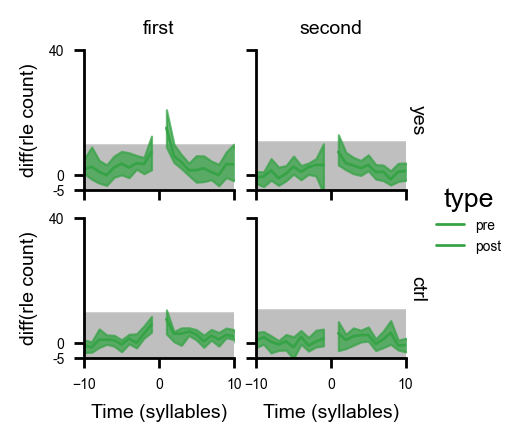

In [45]:
row_order = [
    "yes",
    "ctrl",
]
col_order = ["first", "second"]
stim_duration = 0.25
g = sns.relplot(
    data=_plt_diff.reset_index(),
    x="time_bin",
    y="usage_change",
    ci=95,
    kind="line",
    row="learner",
    row_order=row_order,
    col="session_include",
    col_order=col_order,
    aspect=1,
    height=1,
    n_boot=25,
    hue="type",
    # hue_order=row_order,
    # hue_order=["yes", "ctrl"],
    palette=[geno_palette.snc, geno_palette.snc],
    err_kws={"alpha": 0.75},
    facet_kws={"margin_titles": True, "gridspec_kws": {"wspace": 0.15}},
)
g.set_titles(row_template="{row_name}", col_template="{col_name}")

for j, _col in enumerate(col_order):
    for i, _row in enumerate(row_order):
        g.axes[i][j].fill_between(
            g.axes[i][j].get_xlim(),
            ci_lo.loc[_col],
            ci_hi.loc[_col],
            alpha=0.25,
            facecolor=plt.rcParams["text.color"],
            zorder=-100,
        )

g.set_axis_labels("Time (syllables)", "diff(rle count)")
g.fig.axes[0].set_xlim(0, 40)
plt.ylim(-5, 40)
clean_ticks(g.fig.axes[0], "y", dtype=int, precision=0, zero_symmetry=False)
# g._legend.remove()
plt.xlim(-10, 10)
# g.fig.tight_layout(w_pad=1, pad=1)
savefig(
    g.fig,
    os.path.join(figure_cfg["store_dir"], f"stdp_session_breakout_{stim_duration}"),
    bbox_inches="tight",
)

In [46]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [47]:
use_test = mannwhitneyu

In [48]:
dcts = []
for _lag in range(-10, 11):
    for _session in ["first", "second"]:
        try:
            dat1 = _plt_diff.xs(
                ("yes", _session, _lag),
                level=("learner", "session_include", "time_bin"),
            )["usage_change"]
            dat2 = _plt_diff.xs(
                ("ctrl", _session, _lag),
                level=("learner", "session_include", "time_bin"),
            )["usage_change"]
        except KeyError:
            continue
        dct = {}

        stat, p = use_test(dat1, dat2)
        dct["lag"] = _lag
        dct["stat"] = stat
        dct["p"] = p
        dct["n1"] = len(dat1)
        dct["n2"] = len(dat2)
        dct["session"] = _session
        dct["n_definition"] = "Per-mouse average"
        dct["test"] = str(use_test.__name__)
        dcts.append(dct)

In [49]:
pval_df = pd.DataFrame(dcts)

In [50]:
pval_df["p"] = multipletests(pval_df["p"], method="holm")[1]

In [51]:
import json

In [52]:
with open(os.path.join(proc_dirs["closed_loop_behavior"], "stats_stdp.toml"), "w") as f:
    toml.dump(json.loads(pval_df.to_json()), f)